In [1]:
#importing plugins
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from qiime2 import Artifact

%matplotlib inline

In [2]:
#allocate variables to the folders
data = 'Data'
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'

<div style="background-color: skyblue; padding: 10px;">
    Titles
    </div>
<div style="background-color: aliceblue; padding: 10px;">
    Results

### 1) Alpha rarefaction: choose the sampling depth ###
<div style="background-color: skyblue; padding: 10px;">

In [23]:
! qiime diversity alpha-rarefaction \
    --i-table $data_classified/table-filtered.qza \
    --p-max-depth 10000 \
    --p-iterations 10 \
    --m-metadata-file $data_raw/20250913_metadata_ITS.tsv \
    --o-visualization $data_alpha/alpha-rarefaction.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/alpha-rarefaction.qzv


In [56]:
Visualization.load(f"{data_alpha}/alpha-rarefaction.qzv")

<visualization: Visualization uuid: 02eb71ee-7e93-488c-a7c2-0bac05b4ca7c>

In [57]:
Visualization.load(f"{data_classified}/table-filtered.qzv")

<visualization: Visualization uuid: 5af5a6d9-860b-4a95-a0c1-6dc8d98f9d4c>

<div style="background-color: aliceblue; padding: 10px;">
    A sampling depth of 3000 was chosen because it can retain 87% of the samples and the shannon entropy curves are leveling out there.


### 2) Core metrics creation with sampling depth 3000 ###
<div style="background-color: skyblue; padding: 10px;">

In [19]:
! qiime diversity core-metrics \
  --i-table $data_classified/table-filtered.qza \
  --m-metadata-file $data_raw/20250913_metadata_ITS.tsv \
  --p-sampling-depth 3000 \
  --output-dir $data_alpha/core-metrics-results

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-results/jaccard_pcoa_results.qza
Saved PCoAResults to: Data/dive

### 3) Test data for normal distribution (parametric testing) ###
<div style="background-color: skyblue; padding: 10px;">

In [58]:
#Testen, whether normally distributed!
from scipy.stats import shapiro

shannon_path = f"{data_alpha}/core-metrics-results/shannon_vector.qza"
shannon = q2.Artifact.load(shannon_path).view(pd.Series)

stat, p = shapiro(shannon)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Daten wahrscheinlich normalverteilt")
else:
    print("Daten wahrscheinlich nicht normalverteilt")

Statistics=0.928, p=0.000
Daten wahrscheinlich nicht normalverteilt


<div style="background-color: aliceblue; padding: 10px;">
    The shannon entropy seems not to be normally distributed which leads to using non-parametric statistical tests.

### 5) Kruskal-Wallis: Non-parametric testing ###
<div style="background-color: skyblue; padding: 10px;">

### 5.1) Kruskal-Wallis for the Metadata ITS: ###
<div style="background-color: skyblue; padding: 10px;">

In [24]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $data_raw/20250913_metadata_ITS.tsv \
  --o-visualization $data_alpha/core-metrics-results/shannon-group-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results/shannon-group-significance.qzv


In [3]:
Visualization.load(f"{data_alpha}/core-metrics-results/shannon-group-significance.qzv")

<visualization: Visualization uuid: 379d7e7c-d88e-4b96-879a-de0c2c55c3f8>

### 5.2) Kruskal-Wallis for the Metadata Personal Environment + ITS: ###
<div style="background-color: skyblue; padding: 10px;">

**But first, merge the two metadata files**

In [60]:
its = pd.read_csv("Data/raw/20250913_metadata_ITS.tsv", sep="\t")

sensory = pd.read_csv("Data/raw/20250914_metadata_personal_environmental_sensory_details.tsv", sep="\t")

# merge, keep all ITS
merged = its.merge(
    sensory,
    left_on='person-id',
    right_on='person-id',
    how='left'
)
# safe
merged.to_csv("Data/raw/merged_output.tsv", sep="\t", index=False)


In [27]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $data_raw/merged_output.tsv \
  --o-visualization $data_alpha/core-metrics-results/shannon-group-significance-environment.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results/shannon-group-significance-environment.qzv


In [4]:
Visualization.load(f"{data_alpha}/core-metrics-results/shannon-group-significance-environment.qzv")

<visualization: Visualization uuid: a9deeeba-bad4-4379-9b52-ae4ecd7f3287>

<div style="background-color: aliceblue; padding: 10px;">
Significant in Alpha Diversity (all Metadata included): day 7 aroma, other_fermentations, siblings, completion_time, start_time, sample_type, project, DNA_extraction_plate, plate, label_barcode 1. The sample_type is especially important as a significant parameter because it differentiates between hand-swabs, controls and sourdough samples. 

### 6) Alpha Correlation ###
<div style="background-color: skyblue; padding: 10px;">

### 6.1) Alpha Correlation for the metadata ITS ###
<div style="background-color: skyblue; padding: 10px;">

In [30]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $data_raw/20250913_metadata_ITS.tsv \
  --o-visualization $data_alpha/core-metrics-results/shannon-group-significance-numeric.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results/shannon-group-significance-numeric.qzv


In [19]:
Visualization.load(f"{data_alpha}/core-metrics-results/shannon-group-significance-numeric.qzv")

<visualization: Visualization uuid: 11799f47-fa88-4ba8-b11f-29c54e2e530a>

<div style="background-color: aliceblue; padding: 10px;">
Significant (ITS Metadata  alone): day, amplicon concentration.

### 6.2) Alpha Correlation for the Metadata Personal Environment + ITS: ###
<div style="background-color: skyblue; padding: 10px;">

In [5]:
from qiime2 import Artifact
shannon_series = (Artifact.load(f"{data_alpha}/core-metrics-results/shannon_vector.qza")).view(pd.Series)
shannon = shannon_series.to_frame()

metadata_merged = pd.read_csv(f"{data_raw}/merged_output.tsv", sep = "\t", index_col=0) 

#joining metadata (merged) with the shannon entropy vector
join = shannon.join(metadata_merged, how='inner')
join.index.name = 'sampleID'
join

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


,shannon_entropy,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
sampleID,,,,,,,,,,,,,,,,,,,,,
366291_001-LP4-ITS-0001,6.495475,ATATTTAGGTAT,CTACCGATTGCG,16.10.2024 14:59,ITS,LP4-ITS-0001,1701-d0-r,1701.0,P1,A01,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_002-LP4-ITS-0002,7.360990,AGTACTGCAGGC,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0002,1707-d0-r,1707.0,P1,B01,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366291_003-LP4-ITS-0003,4.436249,CGGGTGAACCAT,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0003,1713-d0-r,1713.0,P1,C01,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366291_004-LP4-ITS-0004,6.159045,CCTGGTCCACGG,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0004,1719-d0-r,1719.0,P1,D01,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
366291_005-LP4-ITS-0005,3.493048,GATAATAGGGAC,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0005,1724-d0-l,1724.0,P1,E01,...,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366292_106-LP4-ITS-0606,0.740284,GGCGTTTGCCTC,CTTGAGAAATCG,16.10.2024 14:59,ITS,LP4-ITS-0606,1707-d21-1,1707.0,P7,F04,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366292_107-LP4-ITS-0607,0.810441,AGGCATCTTACG,ACGGCCCTGGAG,16.10.2024 14:59,ITS,LP4-ITS-0607,1810-d7-1,1810.0,P7,G04,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
366292_108-LP4-ITS-0608,1.231282,TTCAAATATTAG,CTGTAAAGGTTG,16.10.2024 14:59,ITS,LP4-ITS-0608,1705-d14-1,1705.0,P7,H04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6.2.1) Spearman Correlation for Numeric Data Environment + ITS ###
<div style="background-color: skyblue; padding: 10px;">

In [6]:
numeric_metadata = metadata_merged.select_dtypes(include='number')
joined = shannon.join(numeric_metadata, how='inner')

# Spearman-correlations calculations
correlations = joined.corr(method='spearman')['shannon_entropy']
correlations = correlations.drop('shannon_entropy')  #remove shannon entropy as a row
correlations = correlations.dropna()
correlations

person-id                   -0.047755
amplicon_conc               -0.165161
day                         -0.219547
sd_stor_temp                -0.046647
hands_disinfect             -0.042468
                               ...   
maillard_score_D28           0.090498
sour_score_D28              -0.056325
earthy_score_D28            -0.009894
fermented_dairy_score_D28   -0.000613
nutty_score_D28             -0.015429
Name: shannon_entropy, Length: 211, dtype: float64

In [7]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

p_values = {}
for col in numeric_metadata.columns:
    corr, p = spearmanr(joined['shannon_entropy'], joined[col])
    p_values[col] = p

p_values_df = (pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])).join(correlations, how = "inner")
p_values_df = p_values_df.dropna(subset=['p_value'])

pvals = p_values_df['p_value'].values

reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')

p_values_df['p_value_FDR'] = pvals_corr
p_values_df['significant_FDR'] = reject

# show result
p_values_df

,p_value,shannon_entropy,p_value_FDR,significant_FDR
amplicon_conc,0.000287,-0.165161,0.000287,True


<div style="background-color: aliceblue; padding: 10px;">
Only the amplicon_conc is significantly related with alpha diversity incorporating all available Metadata (Environment & ITS). 

### 7) Evaluation sample_type ###
<div style="background-color: skyblue; padding: 10px;">

In [68]:
kruskal_type = pd.read_csv(f"{data_alpha}/kruskal-wallis-pairwise-sample_type.csv", sep = ",", index_col=0)
sig = kruskal_type[kruskal_type['p-value'] <= 0.05]
sig

,Group 2,H,p-value,q-value
Group 1,,,,
control_n (n=6),control_p (n=8),6.016667,1.417139e-02,2.834278e-02
control_n (n=6),hand_swabs (n=338),13.769248,2.066921e-04,6.889735e-04
control_p (n=8),hand_swabs (n=338),22.283990,2.351591e-06,1.175796e-05
control_pcr (n=4),hand_swabs (n=338),10.303129,1.328048e-03,3.320120e-03
hand_swabs (n=338),sourdough (n=122),230.359932,4.975626e-52,4.975626e-51


<div style="background-color: aliceblue; padding: 10px;">
All different sample types (hand_swabs, sourdough and control) are significantly different. Sourdoughs and handswabs have the lowest p-value.

### 8) Kruskal-Wallis: Non-parametric Testing only for Sourdoughs ###
<div style="background-color: skyblue; padding: 10px;">

***8.1) Filtering for Sourdough***

In [41]:
! qiime feature-table filter-samples \
  --i-table $data_classified/table-filtered.qza \
  --m-metadata-file $data_raw/merged_output.tsv  \
  --p-where "sample_type='sourdough'" \
  --o-filtered-table $data_classified/table-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-sourdough_only.qza


In [42]:
! qiime diversity core-metrics \
  --i-table $data_classified/table-filtered-sourdough_only.qza \
  --m-metadata-file $data_raw/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir $data_alpha/core-metrics-results-sourdough_only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-sourdough_only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-sourdough_only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-sourdough_only/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Da

In [43]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_alpha/core-metrics-results-sourdough_only/shannon_vector.qza \
  --m-metadata-file $data_raw/merged_output.tsv \
  --o-visualization $data_alpha/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv


In [8]:
Visualization.load(f"{data_alpha}/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv")

<visualization: Visualization uuid: eb673761-a78b-45dc-a8d9-cfb2e96528fe>

<div style="background-color: aliceblue; padding: 10px;">
The only two conditions that are significant only for sourdough are:
1) background (sterile, non-sterile)
2) sd_bake_last time. The condition sd_bake_last is ignored because it only has so few samples. It will be only continued with the "backgrounnd" as a relevant difference of the change in alpha diversity. 

***8.2.1) Visualization sourdough with Focus on Background sterile vs. non-sterile***

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#load metadata
metadata = pd.read_csv(f"{data_raw}/merged_output.tsv", sep='\t', index_col=0)

shannon_qza = q2.Artifact.load(f"{data_alpha}/core-metrics-results-sourdough_only/shannon_vector.qza")
shannon_df = shannon_qza.view(pd.Series).to_frame(name='shannon')
shannon_df.index.name = 'SampleID'

shannon_df.head()

/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


,shannon
SampleID,
366291_386-LP4-ITS-0386,0.930455
366291_387-LP4-ITS-0387,4.087041
366291_388-LP4-ITS-0388,1.421072
366291_389-LP4-ITS-0389,0.965705
366291_390-LP4-ITS-0390,1.687486


In [13]:
#add shannon entropy to the metadata table
df = shannon_df.join(metadata)
df.head()

,shannon,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
SampleID,,,,,,,,,,,,,,,,,,,,,
366291_386-LP4-ITS-0386,0.930455,GGAAGTGAAGTT,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0386,1820-d21-1,1820.0,P5,B01,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_387-LP4-ITS-0387,4.087041,GATCGGGTCGGA,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0387,1725-d7-1,1725.0,P5,C01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_388-LP4-ITS-0388,1.421072,GTGACCTGATGT,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0388,1806-d14-1,1806.0,P5,D01,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_389-LP4-ITS-0389,0.965705,GCCTACCGCCTA,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0389,1723-d21-1,1723.0,P5,E01,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366291_390-LP4-ITS-0390,1.687486,ATACGGGCGCAT,GCCAAGGATAGG,16.10.2024 14:59,ITS,LP4-ITS-0390,1706-d7-1,1706.0,P5,F01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
!pip install statannot

  Using cached statannot-0.2.3-py3-none-any.whl.metadata (2.6 kB)
Using cached statannot-0.2.3-py3-none-any.whl (10 kB)


In [15]:
!pip install statannotations

  Using cached statannotations-0.7.2-py3-none-any.whl.metadata (7.7 kB)
Using cached statannotations-0.7.2-py3-none-any.whl (39 kB)


In [16]:
import warnings
warnings.filterwarnings('ignore')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

non-sterile vs. sterile: Mann-Whitney-Wilcoxon test two-sided, P_val:1.352e-02 U_stat=1.362e+03


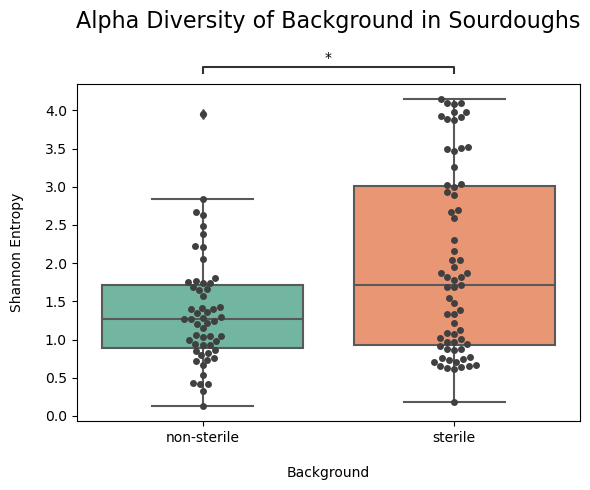

In [18]:
# sterile vs. non sterile
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation

plt.figure(figsize=(6,5))
# remove white space
df['background'] = df['background'].str.strip()

ax = sns.boxplot(x='background', y='shannon', data=df, palette='Set2')
sns.swarmplot(x='background', y='shannon', data=df, color='0.25', ax=ax)

# statistical annotations with Mann-Whitney U Test (non-parametric)
annotator = Annotator(ax, [("sterile", "non-sterile")], 
                      data=df, x='background', y='shannon')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

ax.set_xlabel('Background', labelpad=15)
ax.set_ylabel('Shannon Entropy', labelpad=15)
ax.set_title('Alpha Diversity of Background in Sourdoughs', size=16, pad=40)
plt.tight_layout()
plt.savefig('Data/graphics/boxplot-sterile-nonsterile.png', dpi=300, bbox_inches='tight')
plt.show()


<div style="background-color: aliceblue; padding: 10px;">
The figure above shows the visualization of the contrast of sterile vs. non-sterile background conditions in terms of Alpha Diversity. 

***8.2.2) Visualization sourdough with Focus on Background sterile vs. non-sterile: Change over Days***

In [51]:
!pip install --upgrade seaborn

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

14.0_non-sterile vs. 14.0_sterile: Mann-Whitney-Wilcoxon test two-sided, P_val:6.846e-01 U_stat=2.150e+02
7.0_non-sterile vs. 7.0_sterile: Mann-Whitney-Wilcoxon test two-sided, P_val:1.188e-06 U_stat=3.000e+01
21.0_non-sterile vs. 21.0_sterile: Mann-Whitney-Wilcoxon test two-sided, P_val:1.266e-01 U_stat=2.380e+02


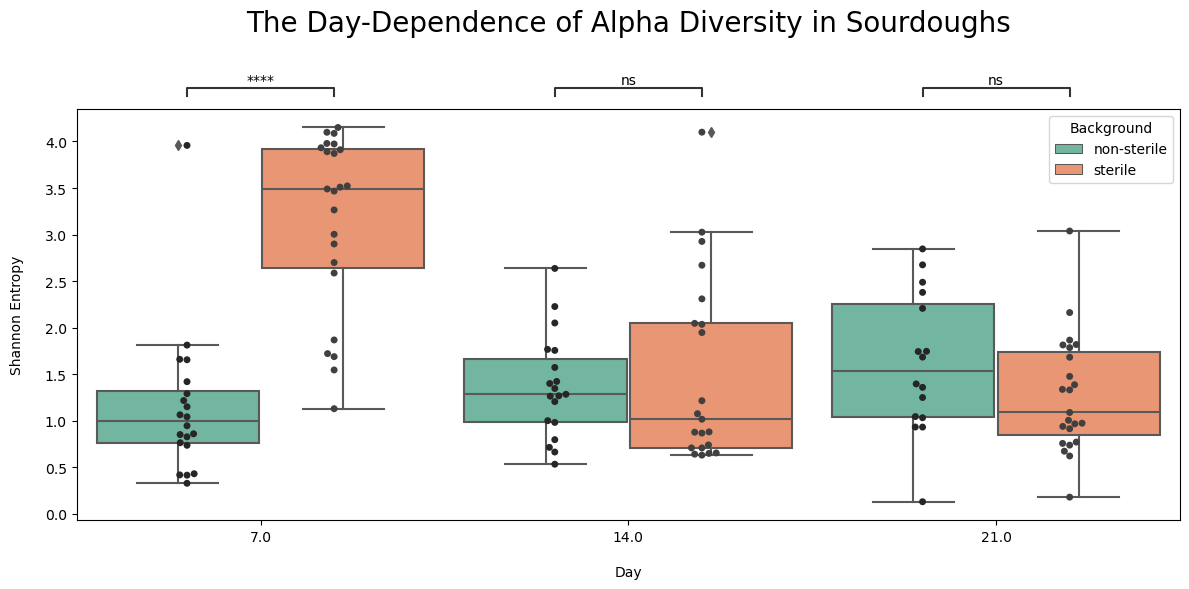

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# convert the "day" column into a string
df['day'] = df['day'].astype(str)

# make graph wider
plt.figure(figsize=(12, 6))  

# chronological order for days
day_order = ['7.0', '14.0', '21.0']

ax = sns.boxplot(x='day', y='shannon', hue='background', data=df, 
                 palette='Set2', order=day_order, width=0.9)  
sns.swarmplot(x='day', y='shannon', hue='background', data=df, 
              dodge=True, color='0.25', ax=ax, legend=False, order=day_order)

# Pairs in der Reihenfolge wie sie auf der x-Achse erscheinen
pairs = [
    (("7.0", "non-sterile"), ("7.0", "sterile")),
    (("14.0", "non-sterile"), ("14.0", "sterile")),
    (("21.0", "non-sterile"), ("21.0", "sterile"))
]

annotator = Annotator(ax, pairs, data=df, x='day', y='shannon', hue='background', order=day_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

ax.set_xlabel('Day', labelpad=15)
ax.set_ylabel('Shannon Entropy', labelpad=15)
ax.set_title('The Day-Dependence of Alpha Diversity in Sourdoughs', size=20, pad=56)
plt.legend(title='Background', loc='best')
plt.tight_layout()
plt.savefig('Data/graphics/boxplot-sterile-day.png', dpi=600, bbox_inches='tight')
plt.show()

<div style="background-color: aliceblue; padding: 10px;">
The figure above shows the visualization of the contrast of sterile vs. non-sterile background conditions in terms of Alpha Diversity and in relation to time. 

In [87]:
# check if equal samples per group:
sample_counts = df.groupby(['day', 'background']).size().unstack()
print("\nAnzahl Proben:")
print(sample_counts)


Anzahl Proben:
background  non-sterile  sterile
day                             
14.0                 19       21
21.0                 16       23
7.0                  20       23


***8.2) Alpha-Correlation for Sourdough***

In [81]:
from qiime2 import Artifact
shannon_series = (Artifact.load(f"{data_alpha}/core-metrics-results-sourdough_only/shannon_vector.qza")).view(pd.Series)
shannon = shannon_series.to_frame()

metadata_merged = pd.read_csv(f"{data_raw}/merged_output.tsv", sep = "\t", index_col=0) 

#joining metadata (merged) with the shannon entropy vector for sourdough
join = shannon.join(metadata_merged, how='inner')
join.index.name = 'sampleID'
join

,shannon_entropy,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
sampleID,,,,,,,,,,,,,,,,,,,,,
366291_386-LP4-ITS-0386,0.930455,GGAAGTGAAGTT,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0386,1820-d21-1,1820.0,P5,B01,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_387-LP4-ITS-0387,4.087041,GATCGGGTCGGA,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0387,1725-d7-1,1725.0,P5,C01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_388-LP4-ITS-0388,1.421072,GTGACCTGATGT,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0388,1806-d14-1,1806.0,P5,D01,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_389-LP4-ITS-0389,0.965705,GCCTACCGCCTA,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0389,1723-d21-1,1723.0,P5,E01,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366291_390-LP4-ITS-0390,1.687486,ATACGGGCGCAT,GCCAAGGATAGG,16.10.2024 14:59,ITS,LP4-ITS-0390,1706-d7-1,1706.0,P5,F01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366292_105-LP4-ITS-0605,2.585969,GCCCACAGGGCC,ATGTATCAATTA,16.10.2024 14:59,ITS,LP4-ITS-0605,1723-d7-1,1723.0,P7,E04,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366292_106-LP4-ITS-0606,0.755112,GGCGTTTGCCTC,CTTGAGAAATCG,16.10.2024 14:59,ITS,LP4-ITS-0606,1707-d21-1,1707.0,P7,F04,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366292_107-LP4-ITS-0607,0.850120,AGGCATCTTACG,ACGGCCCTGGAG,16.10.2024 14:59,ITS,LP4-ITS-0607,1810-d7-1,1810.0,P7,G04,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [82]:
numeric_metadata = metadata_merged.select_dtypes(include='number')
joined = shannon.join(numeric_metadata, how='inner')

# Spearman-correlations calculations
correlations = joined.corr(method='spearman')['shannon_entropy']
correlations = correlations.drop('shannon_entropy')  #remove shannon entropy as a row
correlations = correlations.dropna()
correlations

person-id                   -0.198435
amplicon_conc               -0.373342
day                         -0.209793
sd_stor_temp                 0.075958
hands_disinfect             -0.124895
                               ...   
maillard_score_D28          -0.012428
sour_score_D28              -0.086497
earthy_score_D28            -0.159561
fermented_dairy_score_D28   -0.073466
nutty_score_D28              0.113496
Name: shannon_entropy, Length: 211, dtype: float64

In [83]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

p_values = {}
for col in numeric_metadata.columns:
    corr, p = spearmanr(joined['shannon_entropy'], joined[col])
    p_values[col] = p

p_values_df = (pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])).join(correlations, how = "inner")
p_values_df = p_values_df.dropna(subset=['p_value'])

pvals = p_values_df['p_value'].values

reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')

p_values_df['p_value_FDR'] = pvals_corr
p_values_df['significant_FDR'] = reject

# Ergebnis anzeigen

p_values_df

,p_value,shannon_entropy,p_value_FDR,significant_FDR
person-id,0.028448,-0.198435,0.395721,False
amplicon_conc,0.000023,-0.373342,0.002418,True
day,0.020381,-0.209793,0.395721,False
ANIMAL FEED_D7,0.319256,0.090922,0.867722,False
ANIMAL STABLE_D7,0.335582,0.087916,0.889292,False
...,...,...,...,...
VEGETAL_D21,0.164628,0.126612,0.758721,False
VINEGAR_D21,0.039663,0.186536,0.408289,False
WHOLE GRAIN_D21,0.928003,0.008266,0.980728,False
YEASTY_D21,0.256944,0.103425,0.867722,False


In [86]:
significant_results = p_values_df[p_values_df['significant_FDR'] == True]
significant_results

,p_value,shannon_entropy,p_value_FDR,significant_FDR
amplicon_conc,0.000023,-0.373342,0.002418,True


<div style="background-color: aliceblue; padding: 10px;">
Only the amplicon_conc is significantly related with Alpha Diversity. 

### 9) Kruskal-Wallis: Non-parametric testing only for Handswabs ###
<div style="background-color: skyblue; padding: 10px;">

In [4]:
! qiime feature-table filter-samples \
  --i-table $data_classified/table-filtered.qza \
  --m-metadata-file $data_raw/merged_output.tsv  \
  --p-where "sample_type='hand_swabs'" \
  --o-filtered-table $data_classified/table-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-hand_only.qza


In [6]:
! qiime diversity core-metrics \
  --i-table $data_classified/table-filtered-hand_only.qza \
  --m-metadata-file $data_raw/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir $data_alpha/core-metrics-results-hand_only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-hand_only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-hand_only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-hand_only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-hand_only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-hand_only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-hand_only/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-resu

In [7]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_alpha/core-metrics-results-hand_only/shannon_vector.qza \
  --m-metadata-file $data_raw/merged_output.tsv \
  --o-visualization $data_alpha/core-metrics-results-hand_only/shannon-group-significance-hand.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results-hand_only/shannon-group-significance-hand.qzv


In [10]:
Visualization.load(f"{data_alpha}/core-metrics-results-hand_only/shannon-group-significance-hand.qzv")

<visualization: Visualization uuid: 3366da79-0a69-4a35-b6a7-635a14355381>

<div style="background-color: aliceblue; padding: 10px;">
    Significant differences in these conditions when only including the handswabs: label_barcode 1, DNA_extraction_plate, starting_time, completion_time, yeast_bake_last_time, st_stor_loc, hands, siblings, age_siblings, other_fermentations, hand_injuries, diversity_assumptions, day_7 and 21_aromas.